In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

# Spatial Regression for presences of certain taxon
---
Abstraction dashboard for joininig the data with the model

***
Here I show how to extract different taxonomic information at cell level.
Although there exists a method for building the taxonomic tree within a single cell, the process can be computationally intensive because it depends on extracting the total amount of occurrences in each cell. From there, it traverses from top to bottom the tree looking for the corresponding nodes.

The approach is usefull when one needs a small number of trees but it'll become increasingly slow if the amount of cells or occurrences increases. 

---

## Extracting specific taxonomic levels en each cells

The method studied here makes use of the relationship type `IS_IN` stored in the knowledge graph.

> Developer's note: *There was a problem with the design of the OGM implementation (py2neo.ogm). The retrieval of linked nodes based on a specific relation does not distinguish different labels. In other words it returns the totality of the data that has the  specific relationship given a node.*

> Patchy solution: 
The solution was to include extra methods for the class Cell `has_[taxas]`. This method/attribute returns a graph selector that points to the corresponding nodes.

> Stable Fix: 
Make relationships as specific as possible (given the data). For example, if instead of using the relation type 
* *IS_IN* for (Bursera:Family) -[IS_IN]-> (Grid:Cell) 
change it to:
* *Family_IS_IN* for (Bursera:Family) -[IS_IN]-> (Grid:Cell)
Let's get started.
As usual we need to load the necessary modules


In [2]:
## Let's pick the bats node
bats = pickNode(Order,name='Chiroptera')

In [3]:
ids4bats = bats.getCellsById()

## Random selection of cells.

> Note: Data Arquitecture. For storage reasons I couldn't load the complete world bioclimatic layers. Therefore I needed to put a regional subset that comprises only the Mexican Territory. 
For this reason, it is necessary that any approach for selecting subsamples needs to be constrained (filter) by this geometry. 
We can do that with this:

Obtain list of cells within the Mexican Territory.
> The attribute: `mexican_cells.values` is a generator of the Type: QuerySet. We need to cast it to list for loading all the data in memory.


In [4]:
# Get all cell ids
#selected_cells = mexican_cells
selected_cells = ids4bats
#ids = list(selected_cells.values('pk'))

The UniformRandomCellSample is a method for sampling cells in the example below we give as arguments. 

# Select uniformly random 
We will load the submodule `sampling` from the module `traversals`. This submodule has some sampling methods for selecting objects from the *Knowledge Graph*

Usage: 

> ` sampling.UniformRandomCellSample(list_of_cell_ids, CellNodeClass, sample_size=100, with_replacement=False, random_seed='') `

Returns:
> <\py2neo.ogm.Mex4kmSelection\>

In [5]:
from traversals import sampling as sm
cells_with_bats = bats.is_in.related_class
N = 200
sample_cells = sm.UniformRandomCellSample(ids4bats,cells_with_bats,sample_size=N)

INFO Compiling Query and asking the Graph Database


## Extract richness and Environmental covariates from cells at a given taxonomic level

Inside the module  `traversals` there exists a submodule `strategies` which is composed of different traversal schemes for exploring the *Knowledge Graph*. Here we will use the function: `getEnvironmentalCovariatesFromListOfCells(sample_cells)` which will return a dataframe of the summary statistics for the environmental covariates given a list of Cell objects (`sample_cells`). 



In [6]:
from traversals import strategies as st

In [7]:
%time data = st.getEnvironmentalCovariatesFromListOfCells(sample_cells)

CPU times: user 33.5 s, sys: 1.37 s, total: 34.8 s
Wall time: 2min 25s


In [8]:
%time coords = st.getCentroidsFromListofCells(sample_cells)

CPU times: user 11.4 s, sys: 516 ms, total: 11.9 s
Wall time: 21.8 s


### Build the trees from these cells
Using the function for building cell to tree cells to trees

In [9]:
from drivers.tree_builder import buildTreeNeo

In [10]:
%time cells = list(sample_cells)

CPU times: user 11.5 s, sys: 408 ms, total: 11.9 s
Wall time: 19 s


In [11]:
%time trees = map(lambda c : buildTreeNeo(c),cells)

CPU times: user 11min 9s, sys: 31.4 s, total: 11min 41s
Wall time: 15min 34s


## Calculating Node frequencies
For achiving this we must first obtain the global tree within this region.
It is only with a context in which we can obtain frequencies.
In this case the context is the totallity of the trees. Given that each tree
is a subtree of the tree of life and all share at least a common ancestor (Root)
it is possible to make the union of this trees. As explained before [reference] the
set of taxonomic trees allows a monadic structure (the addition). The union of two trees
will then be called `addition` and will be denoted with the $\times$ symbol.


> ### Implementation note:
It is appealing to `integrate` a list of trees with a reduce function (fold).
* `big_tree = reduce(lambda a,b : a + b ,trees)`
/n Doing so will require a much higher processing time. 

The most efficient way of calculating the union (merge) of a list of trees is by first extracting the occurrences and, by making use of the Taxonomic relationships obtaining the resulting tree.



In [12]:
%time ocs = reduce(lambda a,b : a + b ,map(lambda t : t.occurrences, trees))

CPU times: user 760 ms, sys: 4 ms, total: 764 ms
Wall time: 765 ms


In [13]:
## Ohh! super fast (compared to the other method that takes more than 20 minutes for this sample size)
%time bigtree = TreeNeo(ocs,cell_objects=cells)

CPU times: user 5.53 s, sys: 64 ms, total: 5.59 s
Wall time: 5.6 s


### Now let´s calculate the spatial frequencies

In [14]:
bigtree.countNodesFrequenciesOnList(trees)

INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.025
INFO Going deep 0.025
INFO Going deep 0.025
INFO Going deep 0.04
INFO Going deep 0.04
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.02
INFO Going deep 0.01
INFO Going deep 0.03
INFO Going deep 0.125
INFO Going deep 0.075
INFO Going deep 0.03
INFO Going deep 0.18
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.1
INFO Going deep 0.1
INFO Going deep 0.045
INFO Going deep 0.01
INFO Going deep 0.02
INFO Going deep 0.005
INFO Going deep 0.02
INFO Going deep 0.015
INFO Going deep 0.005
INFO Going deep 0.045
INFO Going deep 0.015
INFO Going deep 0.005
INFO Going deep 0.03
INFO Going deep 0.02
INFO Going deep 0.015
INFO Going deep 0.01
INFO Going deep 0.015
INFO Going deep 0.095
INFO Going deep 0.195
INFO Going deep 0.015
INFO Going deep 0.015
INFO Going deep 0.05
INFO Going deep 0.05
INFO Go

INFO Going deep 0.09
INFO Going deep 0.09
INFO Going deep 0.14
INFO Going deep 0.08
INFO Going deep 0.075
INFO Going deep 0.115
INFO Going deep 0.25
INFO Going deep 0.01
INFO Going deep 0.02
INFO Going deep 0.025
INFO Going deep 0.035
INFO Going deep 0.035
INFO Going deep 0.02
INFO Going deep 0.02
INFO Going deep 0.12
INFO Going deep 0.005
INFO Going deep 0.025
INFO Going deep 0.035
INFO Going deep 0.03
INFO Going deep 0.24
INFO Going deep 0.01
INFO Going deep 0.02
INFO Going deep 0.085
INFO Going deep 0.065
INFO Going deep 0.05
INFO Going deep 0.04
INFO Going deep 0.075
INFO Going deep 0.29
INFO Going deep 0.05
INFO Going deep 0.075
INFO Going deep 0.04
INFO Going deep 0.025
INFO Going deep 0.025
INFO Going deep 0.185
INFO Going deep 0.17
INFO Going deep 0.04
INFO Going deep 0.075
INFO Going deep 0.02
INFO Going deep 0.055
INFO Going deep 0.1
INFO Going deep 0.32
INFO Going deep 0.065
INFO Going deep 0.25
INFO Going deep 0.035
INFO Going deep 0.025
INFO Going deep 0.27
INFO Going deep

INFO Going deep 0.025
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.03
INFO Going deep 0.055
INFO Going deep 0.01
INFO Going deep 0.02
INFO Going deep 0.01
INFO Going deep 0.035
INFO Going deep 0.005
INFO Going deep 0.29
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.02
INFO Going deep 0.02
INFO Going deep 0.005
INFO Going deep 0.015
INFO Going deep 0.04
INFO Going deep 0.05
INFO Going deep 0.025
INFO Going deep 0.025
INFO Going deep 0.005
INFO Going deep 0.035
INFO Going deep 0.085
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.03
INFO Going deep 0.03
INFO Going deep 0.005
INFO Going deep 0.015
INFO Going deep 0.005
INFO Going deep 0.06
INFO Going deep 0.065
INFO Going deep 0.015
INFO Going deep 0.005
INFO Going deep 0.075
INFO Going deep 0.015
INFO Going deep 0.015
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.015
INFO Going deep 0.47
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO G

INFO Going deep 0.025
INFO Going deep 0.02
INFO Going deep 0.015
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.015
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.015
INFO Going deep 0.005
INFO Going deep 0.02
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.03
INFO Going deep 0.02
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.045
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.02
INFO Going deep 0.02
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.02
INFO Going deep 0.025
INFO Going deep 0.11
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.02
INFO Going deep 0.015
INFO Go

INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.015
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.03
INFO Going deep 0.03
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.045
INFO Going deep 0.015
INFO Going deep 0.04
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.03
INFO Going deep 0.01
INFO Going deep 0.015
INFO Going deep 0.045
INFO Going deep 0.015
INFO Going deep 0.02
INFO Going deep 0.015
INFO Going deep 0.055
INFO Going deep 0.055
INFO Going deep 0.025
INFO Going deep 0.03
INFO Going deep 0.015
INF

INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.015
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.015
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
IN

INFO Going deep 0.01
INFO Going deep 0.04
INFO Going deep 0.045
INFO Going deep 0.015
INFO Going deep 0.01
INFO Going deep 0.015
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.02
INFO Going deep 0.085
INFO Going deep 0.175
INFO Going deep 0.22
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.04
INFO Going deep 0.005
INFO Going deep 0.015
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.06
INFO Going deep 0.06
INFO Going deep 0.02
INFO Going deep 0.02
INFO Going deep 0.025
INFO Going deep 0.05
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.025
INFO Going deep 0.09
INFO Going deep 0.01
INFO Going deep 0.02
INFO Going deep 0.065
INFO Going deep 0.025
INFO Going deep 0.145
INFO Going deep 0.175
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.02
INFO Going deep 0.02
INFO Going deep 0.04
INFO Going d

INFO Going deep 0.06
INFO Going deep 0.06
INFO Going deep 0.085
INFO Going deep 0.13
INFO Going deep 0.165
INFO Going deep 0.18
INFO Going deep 0.025
INFO Going deep 0.035
INFO Going deep 0.045
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.015
INFO Going deep 0.025
INFO Going deep 0.015
INFO Going deep 0.065
INFO Going deep 0.055
INFO Going deep 0.005
INFO Going deep 0.025
INFO Going deep 0.04
INFO Going deep 0.005
INFO Going deep 0.125
INFO Going deep 0.14
INFO Going deep 0.01
INFO Going deep 0.015
INFO Going deep 0.005
INFO Going deep 0.06
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.015
INFO Going deep 0.005
INFO Going deep 0.11
INFO Going deep 0.015
INFO Going deep 0.005
INFO Going deep 0.02
INFO Going deep 0.1
INFO Going deep 0.015
INFO Going deep 0.075
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.035
INFO Going deep 0.015
INFO Go

INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.015
INFO Going deep 0.015
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.015
INFO Going deep 0.05
INFO Going deep 0.1
INFO Going deep 0.015
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.025
INFO Going deep 0.005
INFO Going deep 0.015
INFO Going deep 0.015
INFO Going deep 0.005
INFO Going deep 0.025
INFO Going deep 0.03
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.07
INFO Going deep 0.035
INFO Going deep 0.02
INFO Going deep 0.005
INFO Going deep 0.02
INFO Going deep 0.015
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.02
INFO Going deep 0.005
INFO Going deep 0.035
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.015
INFO Going deep 0.04
INFO Going deep 0.045
INFO Going deep 0.05
INFO Going deep 0.01
INFO Going deep 0.015
INFO Going deep 0.03
INFO Going deep 0.425
INFO Going deep 0.085
INFO G

INFO Going deep 0.01
INFO Going deep 0.02
INFO Going deep 0.015
INFO Going deep 0.035
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.02
INFO Going deep 0.02
INFO Going deep 0.015
INFO Going deep 0.01
INFO Going deep 0.02
INFO Going deep 0.02
INFO Going deep 0.005
INFO Going deep 0.025
INFO Going deep 0.06
INFO Going deep 0.045
INFO Going deep 0.03
INFO Going deep 0.055
INFO Going deep 0.035
INFO Going deep 0.045
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.02
INFO Going deep 0.085
INFO Going deep 0.035
INFO Going deep 0.01
INFO Going deep 0.03
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.02
INFO Going deep 0.025
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.045
INFO Going deep 0.02
INFO Going deep 0.005
INFO Going deep 0.045
INFO Going deep 0.035
INFO Going deep 0.04
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.02
INFO Go

INFO Going deep 0.015
INFO Going deep 0.015
INFO Going deep 0.015
INFO Going deep 0.055
INFO Going deep 0.01
INFO Going deep 0.045
INFO Going deep 0.015
INFO Going deep 0.005
INFO Going deep 0.02
INFO Going deep 0.005
INFO Going deep 0.31
INFO Going deep 0.035
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.04
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.055
INFO Going deep 0.005
INFO Going deep 0.055
INFO Going deep 0.07
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.035
INFO Going deep 0.01
INFO Going deep 0.105
INFO Going deep 0.02
INFO Going deep 0.02
INFO Going deep 0.01
INFO Going deep 0.04
INFO Going deep 0.005
INFO Going deep 0.04
INFO Going deep 0.03
INFO Going deep 0.025
INFO Going deep 0.005
INFO Going deep 0.065
INFO Going deep 0.04
INFO Going deep 0.015
INFO Going deep 0.02
INFO Going deep 0.005
INFO Going deep 0.17
INFO Going deep 0.035
INFO Going deep 0.035
INFO Going deep 0.005
INFO 

INFO Going deep 0.79
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.005
INFO Going deep 0.01
INFO Going deep 0.01
INFO Going deep 0.015
INFO Going deep 0.015
INFO Going deep 0.015


0.05

In [15]:
soyunagraphica = bigtree.toNetworkx(depth_level=6)
nombres = bigtree.toNetworkx(depth_level=5)


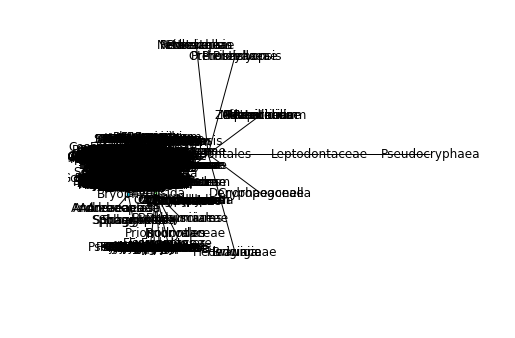

In [16]:
import networkx as nt
from networkx.drawing.nx_agraph import graphviz_layout
extractNames = lambda graph : {k:v for (k,v) in map(lambda n : (n,n.name),
                                                    graph.nodes())}
extractColors = lambda graph :  map(lambda n : 
                                    n.level,graph.nodes())
extractfreqs = lambda graph : np.array(map(lambda (k,v) : 
                        v['freq'],graph.nodes(data=True)))
root = bigtree.node
pos = graphviz_layout(soyunagraphica,prog='circo',root=root.node.name)
nt.draw(soyunagraphica,pos,labels=extractNames(soyunagraphica),
        node_color=extractColors(soyunagraphica), 
        node_size=extractfreqs(soyunagraphica)*100
       )
#nt.draw(soyunagraphica,pos)
plt.show()

In [17]:
soyunagraphica.size()

4205

we will use `between_centrality` for obtaining a relevant metric of node importance. We will add this new value to the graph as a new attribute: `centrality` 

In [18]:
%time gigi = nt.algorithms.betweenness_centrality(soyunagraphica)

CPU times: user 51min 39s, sys: 824 ms, total: 51min 39s
Wall time: 51min 48s


Here we'll add the between centrality as a new attribute:


In [19]:
nt.set_node_attributes(soyunagraphica, 'betweenness', gigi)

In [20]:
extractbetweeness = lambda graph :  np.array(map(lambda (k,v) : v['betweenness'],
                                                 graph.nodes(data=True)
                                                ))

In [21]:
bc = 1 + (extractbetweeness(soyunagraphica) * 7000)
freqs = extractfreqs(soyunagraphica) * 2000


/opt/conda/envs/biospytial/lib/python2.7/site-packages/pygraphviz/agraph.py:1338: RuntimeWarning: Warning: specified root node "LUCA" was not found.Using default calculation for root node

  warnings.warn(b"".join(errors), RuntimeWarning)


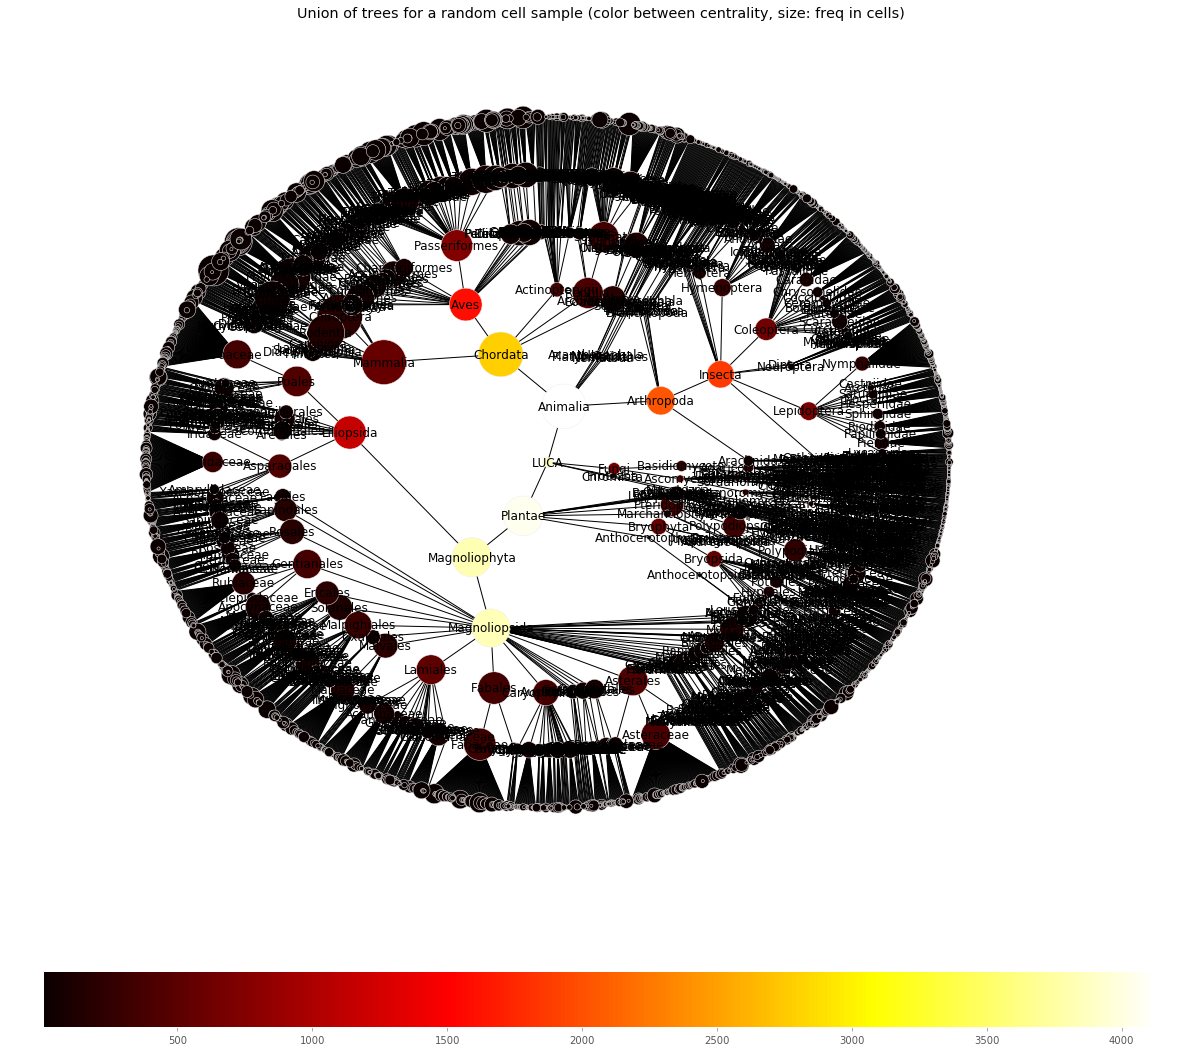

In [22]:
import matplotlib as mtp
plt.figure(figsize=(20,20))
plt.title("Union of trees for a random cell sample (color between centrality, size: freq in cells)")
plt.xlabel("Between Centrality")
root = bigtree.node
pos = graphviz_layout(soyunagraphica,prog='twopi',root=root.node.name)
nt.draw(soyunagraphica,pos,
       labels=extractNames(nombres),
        #node_color=extractColors(soyunagraphica), 
        node_color=bc, 
        node_size=freqs,
        cmap=plt.cm.hot,
        title="Union of trees for a random cell sample"
       )
#nt.draw(soyunagraphica,pos)
#plt.show()
norm = mtp.colors.Normalize(vmin=min(bc),vmax=max(bc))
sm = plt.cm.ScalarMappable(cmap=plt.cm.hot, norm=norm)
sm.set_array([])
plt.colorbar(sm,orientation="horizontal",pad=-0.01)

plt.savefig("/outputs/graph_centrality.png", format="PNG")



> ### Figure 1: 
The global tree reulting by fusing the selected random cells. The color of the node represents the taxonomic level. The size is proportional to the between centrality.

In [23]:
cosas = soyunagraphica.nodes(data=True)

In [24]:
cosas.sort(key=lambda (k,v) : v,reverse=True)

In [25]:
orders = filter(lambda (k,v) : k.level==4,cosas)

In [26]:
orders

[(<TreeNode type: Order id = 729 name: Passeriformes>,
  {'betweenness': 0.10803990537294757,
   'freq': 0.5,
   'level': 4,
   'richness': 23313}),
 (<TreeNode type: Order id = 797 name: Lepidoptera>,
  {'betweenness': 0.09875086407713168,
   'freq': 0.17,
   'level': 4,
   'richness': 2238}),
 (<TreeNode type: Order id = 1470 name: Coleoptera>,
  {'betweenness': 0.09178903281060674,
   'freq': 0.25,
   'level': 4,
   'richness': 3250}),
 (<TreeNode type: Order id = 408 name: Lamiales>,
  {'betweenness': 0.07584962399209857,
   'freq': 0.44,
   'level': 4,
   'richness': 1186}),
 (<TreeNode type: Order id = 1369 name: Poales>,
  {'betweenness': 0.06390912454137444,
   'freq': 0.46,
   'level': 4,
   'richness': 1462}),
 (<TreeNode type: Order id = 1169 name: Asparagales>,
  {'betweenness': 0.06223470993595364,
   'freq': 0.29,
   'level': 4,
   'richness': 790}),
 (<TreeNode type: Order id = 414 name: Asterales>,
  {'betweenness': 0.06095287767383083,
   'freq': 0.455,
   'level': 4,


In [27]:
## Let´s extract the frequency values and store it as a dictionary for further use in the g

In [28]:
extractfreqs = lambda graph : np.array(map(lambda (k,v) : 
                        v['freq'],graph.nodes(data=True)))

In [29]:
presences_in_list = extractfreqs(soyunagraphica)

## Here we will get the richness for all bats

In [ ]:
bats_richness_per_cell = map(lambda tree :tree.to_Animalia.to_Chordata.to_Mammalia.to_Chiroptera.richness,trees )

In [ ]:
bats_richness_per_cell = pd.DataFrame({'bats_rich' : bats_richness_per_cell})

In [ ]:
coords_cells = st.getCentroidsFromListofCells(cells)

In [ ]:
datafull = pd.concat([bats_richness_per_cell,coords_cells,data],axis=1)

In [ ]:
datafull.loc[:10]

In [ ]:
### Let's save it for posterior use
datafull.to_csv('/outputs/bats_richness.csv')

In [ ]:
from sketches.models import Country
from mesh.models import MexMesh

Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)

## Obtaining the predictors
In this case we will bring all the variables to start working with everything

In [ ]:
from raster_api.tools import RasterData
from raster_api.models import raster_models_dic as models


### Obtaining everything

In [ ]:
datadict = { key : RasterData(models[key],border=Mexico.geom) for key,value in models.iteritems()}

In [ ]:
#from django.db import connections
#connections.close_all()

In [ ]:
## Without resamling (whole data)
pixel_size = 0.25
%time datacube_field = map(lambda raster : raster.rescale(pixel_size),datadict.itervalues())
datacube = datacube_field

In [ ]:
map(lambda (k,d) : d.display_field(title=k,origin='Lower'),datadict.iteritems())

## For the moment we don't want to do temporal analysis so we need to aggregate the array by the mean.

Using the new 'resample' method

In [ ]:
# Take mean of evetything
cubes = map(lambda (k,v): np.mean(v.toNumpyArray(),axis=0), datadict.iteritems())

The coordinates are the same so, we can extract the them with getCoordinates and then append everything as a flat array

In [ ]:
coords = map(lambda (k,v) : v.getCoordinates(),datadict.iteritems())

In [ ]:
coords = pd.concat(coords,axis=1)

In [ ]:
coords1 = coords[[0,1]]

In [ ]:
## Oke I need a way to extract the dataframe, maybe aggregate it by mean 
dataframe_cube = map(lambda cube: pd.DataFrame(cube.flatten()),cubes)

In [ ]:
datacube = pd.concat(dataframe_cube,axis=1)

In [ ]:
datacube = pd.concat([datacube,coords1],axis=1)

In [ ]:
datacube.columns = datadict.keys() + list(coords1.columns)

In [ ]:
datacube_clean.columns

In [ ]:
datacube.loc[:10]
datacube_clean = datacube.dropna()

In [ ]:
## Convert to geopandas
from external_plugins.spystats.spystats import tools as tl
datacube_clean = tl.toGeoDataFrame(datacube_clean,xcoord_name='Longitude',ycoord_name='Latitude')

# Bayesian Modelling

The Model is an inhomogeneous Poisson process.

$y(x) \sim Poisson(\lambda(x)) $

$$ \lambda(x) = exp\{\alpha + S(x)\}$$

Where $S(x)$ is a Gaussian Process such that:
$$S(x) \sim MVN(0,\sigma^2 \rho(||x - x'||) $$

For this particular case:
$$\rho = Matern(\phi,\kappa = \frac{3}{4}) + \tau^2$$

I'm using a Bayesian approach with parameters $\phi$ and $\tau$ as random variables with it's corresponding priors.


In [ ]:
datafull.columns

In [ ]:
import pymc3 as pm
#datafull.columns = [u'n_Family', u'Longitude', u'Latitude', u'Elevation_mean',
#       u'MaxTemperature_mean', u'MeanTemperature_mean', u'MinTemperature_mean',
#       u'Precipitation_mean', u'SolarRadiation_mean', u'Vapor_mean',
#       u'WindSpeed_mean', u'geometry']

In [ ]:
datafull[:10]

In [ ]:
ndatafull = datafull.replace('N.A.',np.nan)

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import OLS
from statsmodels.genmod.generalized_linear_model import GLM
glmodel = GLM.from_formula('bats_rich ~ Elevation_mean + MeanTemperature_mean',data=ndatafull,family=sm.families.Poisson(sm.families.links.log))
#glmodel = OLS.from_formula('bats_rich ~ WindSpeed_mean',data=datafull)
#glmodel = OLS(ndatafull.bats_rich.values,ndatafull.WindSpeed_mean.values)
res = glmodel.fit()
print(res.summary())


z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])

In [ ]:
z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])
print(coefs)

In [ ]:
## Analysis, GP only one parameter to fit
# The variational method is much beter.
from pymc3.variational.callbacks import CheckParametersConvergence

with pm.Model() as model:
    sigma = 1.0
    #range_a=10.13
    
    
    tau = pm.Uniform('tau',0,5.0)
    #sigma = pm.Flat('sigma')
    #phi = pm.HalfNormal('phi',mu=8,sd=3)
    #phi = pm.Uniform('phi',6,12)
    phi = pm.Uniform('phi',0,15)
    
    Tau = pm.gp.cov.Constant(tau)
    
    cov = sigma * pm.gp.cov.Matern32(2,phi,active_dims=[0,1]) + Tau
    #K = cov(grid[['Lon','Lat']].values)
    #phiprint = tt.printing.Print('phi')(phi)
    
    
    mf = pm.gp.mean.Linear(coeffs=coefs,intercept=res.params.values[0])

    
    
    
    
    ## The latent function
    gp = pm.gp.Latent(cov_func=cov)
    
    
    
    
    
    ## I don't know why this
    #f = gp.prior("latent_field", X=data[['Longitude','Latitude']].values,reparameterize=False)
    
    f = gp.prior("latent_field", X=ndatafull[['Longitude','Latitude','Elevation_mean','MaxTemperature_mean']].values,reparameterize=False)
    
    
    
    
    
    
    
    #f_print = tt.printing.Print('latent_field')(f)
    
    y_obs = pm.Poisson('y_obs',mu=np.exp(f),observed=datafull[['bats_rich']].values)
    
    #y_obs = pm.MvNormal('y_obs',mu=np.zeros(n*n),cov=K,observed=grid.Z)

    #gp = pm.gp.Latent(cov_func=cov,observed=sample)
    # Use elliptical slice sampling
    #ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K)
    #step = pm.HamiltonianMC()
    #step = pm.Metropolis()
    #%time trace = pm.sample(5000,step)#,tune=0,chains=1)
    ## Variational
    
    %time mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
    %time trace = mean_field.sample(draws=5000)

#with model:    
    
    ## For predicting
    #%time f_star = gp.conditional("f_star", data_star.iloc[:,1:3].values)
    #%time f_star = gp.conditional("f_star", small_sample.iloc[:,1:3].values)
    %time f_star = gp.conditional("f_star", datacube_clean[['Longitude','Latitude','Elevation','MeanTemperature']].values)

    ## Full data
    ##%time f_star = gp.conditional("f_star",elev_data.iloc[:,1:3].values)


    
#with model:
    ## sampling predictions posterior predictive checks
    pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=10)

                    


In [ ]:
preds = pd.DataFrame(pred_samples['f_star']).transpose()

In [ ]:
preds['mean_sample'] = preds.mean(axis=1)

In [ ]:
#preds['idx'] = data_star.index.values
preds['idx'] = datacube_clean.index.values

In [ ]:

#test1 = data_s.merge(preds,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))
test1 = datacube.merge(preds,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))
## Only the values of small_sample
#test2 = elev_data.merge(preds,how='inner',left_index=True,right_on='idx',suffixes=('_obs','_pred'))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 9));
plt.scatter(test1.Longitude,test1.Latitude,c=test1.mean_sample)
plt.scatter(datafull.Longitude,datafull.Latitude,c=datafull.bats_rich,cmap=plt.cm.Greys,s=90)
plt.colorbar()

# Convert to a raster format.
 ## Motivation
 It's important for visualization and compatibility with GIS software to generate the results in a standard raster format.
*Biospytial* Has incorporated tools for reading and converting to the standard raster formats. In this case Geotif.

In [ ]:
## Import raster container
from raster_api.tools import RasterContainer

### The easiest way is to take the metadata (geospatial parameters) from one of the RasterData we used as covariates

In [ ]:
elv_rast = datadict['Elevation'].rasterdata

In [ ]:
predicted_data = test1.mean_sample.values

In [ ]:
ncounts_families = RasterContainer(predicted_data,use_metadata_from=elv_rast)

In [ ]:
ncounts_families.display_field(band=1,origin='Lower',title='log(family richness)')

In [ ]:
np.log(2)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
plt.imshow(ncounts_families.rasterdata.bands[1].data(),origin='Lower')
plt.colorbar(orientation='horizontal')

### Export to Geotif

In [ ]:
ncounts_families.exportToGeoTiff('bats_richness_fromsample')

There are several parameters hidden here:
    1. The size of the predictors grid
    2. The sample size of the training data
    3. The bayesian hyperparameters

## For implementing today
* The modeller function (structure):
    
   * Inputs: 
    
    ** Dataframe for training data
    
    ** numpy n-array or dataframe for predictors
    
    ** Model (specified as Pymc3 model)
    
    * Outputs:
        
        *** The new RasterContainer with rthe bands as: log, exp and expit (in case binomial)
        
* Seems like needs to be a premodelr to select the cells, the geometry, etc.




In [ ]:
ncounts_families.rasterdata.bands[0].data().shape

## stages
1. Build a function for extracting the predictors given a scale parameter
2. Build a function for the "premodeling"
3. Build a function for bundling everything and return the prediction (needs to accept a model)

> Models to run
Show two maps of taxa. e.g. Agave and Bats for instance

Then also show the matrix distance for trees 


In [5]:
import IPython.display  as dd

In [1]:
from IPython.display import GeoJSON


ImportError: cannot import name GeoJSON

In [46]:
from IPython.display import GeoJSON

GeoJSON(data={
     "type": "Feature",
     "geometry": {
         "type": "Point",
         "coordinates": [-81.327, 296.038]
     }
 },
 url_template="http://s3-eu-west-1.amazonaws.com/whereonmars.cartodb.net/{basemap_id}/{z}/{x}/{y}.png",
 layer_options={
     "basemap_id": "celestia_mars-shaded-16k_global",
     "attribution" : "Celestia/praesepe",
     "minZoom" : 0,
     "maxZoom" : 18,
 })

ImportError: cannot import name GeoJSON

In [ ]:
ediriweera patabandige